<h1 align="center"> Image Captioning </h1>

Итак, мы сейчас займемся image captioning =)
![img](https://i.imgur.com/obITaMl.png)

## Описание

Image captioning -- это когда мы подаем модели каритнку, а она возвращает нам текст с описанием того, что на ней изображено. 

Как мы знаем из нашего замечательного курса, с картинками лучше всегоработают модели CNN, а с текстом -- RNN. Поэтому логично, что для image captioning нужно совместить и то, и другое =)

Для удобства (и, в какой-то степени, экономии времени), мы будем строить не одну большую модель CNN+RNN, которая будет кушать картинку и выдавать текст, а разобьем ее на две. Первая модель будет кушать картинку и выдавать вектор картинки, а вторая модель будет кушать этот вектор и генерировать текст. Вектор, по сути, будет числовым "описанием" картинки, в котором будет содержаться вся необходимая информация для второй сети, чтобы та смогла нагенерить текста с описанием. Короче, как в автоэнкодерах)

## План

Итак, как мы будем действовать:

Датасет: MSCOCO: [описание](http://cocodataset.org/#download), [ссылка для скачивания](https://yadi.sk/d/iK9ZtggjJcGKIA)

### Базовая часть:
1. Скачаем датасет (векторы картинок и соответствующие описания) и предобработаем описания так, как мы любим. Ну, токенизация там (да, в 100500-ый раз, только теперь сами)
2. В качестве первой сети возьмем Inception-v3 и скачаем к ней предобученные веса (тренировать и генерировать веса -- это оч долго, поверьте мне). 
3. Напишем вторую сетку, которая будет брать векторы из Inception-v3 и генерить описания.
4. Обучим вторую сеть на MSCOCO

### Вариативная часть:
Что еще можно сделать:
1. Нагуглить другой датасет (в MSCOCO видны паттерны -- все тексты выглядят как "хто-то с чем-то что-то делает")
2. Взять не Inseption-v3, а другую предобученную сеть
3. Запилить аттеншен во второй сети (не, ну а вдруг)
4. Написать бота ))0))
5. Whatever comes to your head

## Базовая часть:

### 1. Предобработка текстов из датасета

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd  ./drive/MyDrive/DLS\ 2\ sem/Image\ Captioning/

/content/drive/MyDrive/DLS 2 sem/Image Captioning


In [3]:
!ls

 234.jpg			  Image_captioning_new.ipynb
 555.jpg			  Image_captioning_with_TF.ipynb
 att-model_25epoch.pt		  img.jpg
 att_model_8_epoch.pt		  model_20epoch.pt
 beheaded_inception3.py		  model_30epoch.pt
 best-full-att-model_20epoch.pt   old_versions
 best-val-model.pt		  __pycache__
 data				  -q
 Flickr30k+MobileNet		 'Копия Image_captioning_final.ipynb'
 Image_captioning_final.ipynb


In [4]:
import numpy as np
import json

# загружаем датасет
img_codes = np.load("data/image_codes.npy")
captions = json.load(open('data/captions_tokenized.json'))

In [5]:
# посмотрим на датасет
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


Как можно видеть, в датасете все captions (тексты-описания) уже токенизированы и приведены в нижний регистр. Нам осталось сделать следующее:

1. Добавить ко всем описаниям символы начала и конца предложения 
2. Посчитать частоту встречания каждого слова из словаря и оставить тольео те, которые встречаются больше Х раз (например, Х=5)
3. Создать словарь из оставшихся слов + символов начала, конца предложения и PAD символа
4. Написать функцию, которая будет возвращать батч из описаний. Мы такое уже делали на прошлвх занятиях. Батч должен выглядеть примерно так:
ВАЖНО! Почему я советую писать отдельную функцию, которая генерирует батч: дело в том, что в датасете для каждой картинки есть несколько (5-7) различных описаний. Когда создаете батч, лучше, чтобы в нем были разные картинки, и к каждой картинке при создании батча выбирать одно из ее описаний рандомно. Это проще реализовать в отдельной функции (но вы, конечно, можете писать код как хотите)
5. Поделить выборку на train/test

[[   1,  525, 8955, 5392, 9640, 4713, 7470,  525, 7341, 2296, 7696,2,    3,    3,    3,    3,    3,    3,    3],
   
[   1,  525, 8955, 6784, 3557,  525, 7341, 2296,    2,    3,    3,3,    3,    3,    3,    3,    3,    3,    3],

[   1,  525, 8955, 9209, 3557, 5486, 8335, 3071, 2296,    2,    3,3,    3,    3,    3,    3,    3,    3,    3],

[   1, 6292, 1508, 8955, 9209, 6784, 3557, 3071, 6971, 5520, 7696,2,    3,    3,    3,    3,    3,    3,    3],

[   1,  525, 8955, 6784, 3557,  525, 7341, 6919, 2919, 6292,  250,393,  525, 4618, 8335, 6292, 7882, 7696,    2]]
         
То есть, короткие предложения дополняются PAD символами, слишком длинные обрезуются, в начале и конце по коду символа начал и конца предложения.

Уверена, эта часть вам покажется очень знакомой и легкой =)

In [6]:
import torchtext
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.distributions import Categorical
import random

from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm
import pdb

device = "cuda" if torch.cuda.is_available() else "cpu"

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [7]:
vocabulary = torchtext.vocab.build_vocab_from_iterator([sent[:-1].split() for cap in captions for sent in cap], min_freq=5, specials=['<pad>', '<sos>', '<eos>', ])

In [8]:
img_train, img_val, captions_train, captions_val = train_test_split(img_codes, captions, test_size=0.2)

In [9]:
class ImageCaptionDataset(Dataset):    
    def __init__(self, img_codes, captions, vocab, max_len=20, specials=['<pad>', '<sos>', '<eos>', ]):
      self.vocab = vocab
      self.max_len = max_len
      self.pad = specials[0]
      self.sos = specials[1]
      self.eos = specials[2]      
      self.img_vec = img_codes
      self.captions = self._get_captions(captions)

    def __getitem__(self, item):
        return torch.FloatTensor(self.img_vec[item]), torch.LongTensor(self.captions[item])

    def _get_captions(self, captions):
        res = np.zeros((len(captions), self.max_len))
        for i, cap in tqdm(enumerate(captions)):
            caption = random.choice(cap).rstrip('.').split()
            сaption_idx = np.array([self.vocab[self.sos]], dtype=int)    
            for word in caption:
                if len(сaption_idx) < self.max_len - 1:
                    if word in self.vocab:
                        сaption_idx = np.append(сaption_idx, self.vocab[word])
                    else:
                        continue
                else:
                    сaption_idx = np.append(сaption_idx, self.vocab[self.eos])
                    break
            if len(сaption_idx) < self.max_len:
                сaption_idx = np.append(сaption_idx, self.vocab[self.eos])
            if len(сaption_idx) < self.max_len:
                сaption_idx = np.append(сaption_idx, np.zeros(self.max_len - len(сaption_idx)))
          
            res[i] = сaption_idx
        return res

    def __len__(self):
      return len(self.img_vec)


In [10]:
train_data = ImageCaptionDataset(img_train, captions_train, vocabulary)
val_data = ImageCaptionDataset(img_val, captions_val, vocabulary)

In [11]:
train_loader = DataLoader(train_data, batch_size=160, num_workers=2, shuffle=True, drop_last=True)
val_loader = DataLoader(val_data, batch_size=160, num_workers=2, shuffle=True, drop_last=True)

### 2. Напишем свою сетку из RNN для вывода описаний


Сейчас мы напишем сеть, которая будет получать выходы CNN-сетки (эмбеддинги картинок) и преобразовывать их в текст.

In [12]:
class Attention(nn.Module):
    def __init__(self, hid_dim, att_dim):
        super(Attention, self).__init__()
        self.att_dim = att_dim
        self.hid_dim = hid_dim
        self.W1 = nn.Linear(1, self.att_dim)
        self.W2 = nn.Linear(self.hid_dim, self.att_dim)
        self.V = nn.Linear(self.att_dim, 1)

    def forward(self, enc_out, dec_hidden):
        """
        enc_out [batch, enc_ch]
        dec_out [batch, dec_hidden_dim]
        """
        w1 = self.W1(enc_out.unsqueeze(2))
        w2 = self.W2(dec_hidden)
        energy = torch.tanh(w1 + w2.unsqueeze(1))
        att_weights = torch.softmax(self.V(energy).squeeze(2), dim=1)
        weighted_encoding = enc_out * att_weights
        return weighted_encoding, att_weights

In [13]:
class CaptionNet(nn.Module):
    def __init__(self, vocab_size, device, cnn_feature_size=2048,  emb_dim=256, hidden_dim=256, n_layers=2, 
                 dropout=0.2, pad_idx=0):
        super(self.__class__, self).__init__()
        self.device = device
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx = pad_idx)
        self.fc_h = nn.Linear(cnn_feature_size, hidden_dim)
        self.fc_c = nn.Linear(cnn_feature_size, hidden_dim)
        self.n_layers = n_layers 
        self.rnn = nn.LSTM(cnn_feature_size + emb_dim, hidden_dim, num_layers=n_layers, dropout=dropout, bidirectional=False)
        self.fc = nn.Linear(hidden_dim, vocab_size)
        self.attn = Attention(256, 512)
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, image_vectors, captions_ix, hid=None, cell=None, TF=1):
        if isinstance(hid, torch.Tensor):
            h = hid
        else:
            h = self.fc_h(image_vectors.repeat(self.n_layers,1,1))
        if isinstance(cell, torch.Tensor):
            c = cell            
        else:
            c = self.fc_c(image_vectors.repeat(self.n_layers,1,1)) 
        embedded = self.dropout(self.embedding(captions_ix).permute(1,0,2))
        sent_len = embedded.shape[0]
        batch_size = embedded.shape[1]        
        logits = torch.zeros(sent_len, batch_size, self.vocab_size).to(self.device)
        input = embedded[0].unsqueeze(0)
        if sent_len == 1:
            w_enc, _ = self.attn(image_vectors, h[-1])
            output, (h, c) = self.rnn(torch.cat((input, w_enc.unsqueeze(0)),dim=2), (h, c))
            logit = self.fc(output)
            return logit, h, c
        for t in range(1, sent_len):
            w_enc, _ = self.attn(image_vectors, h[-1])
            output, (h, c) = self.rnn(torch.cat((input, w_enc.unsqueeze(0)),dim=2), (h, c))
            logit = self.fc(output)
            logits[t] = logit
            teacher_force = random.random() < TF
            top1 = self.embedding(logit.argmax(-1))
            input = embedded[t].unsqueeze(0) if teacher_force else top1            
        return logits 

In [14]:
def compute_loss(network, image_vectors, captions_ix, TF=1):
    logits = network(image_vectors, captions_ix, TF)
    criterion = nn.CrossEntropyLoss(ignore_index=0)
    loss = criterion(logits[1:].permute(0,2,1),captions_ix[:,1:].permute(1,0))  
    return loss

In [18]:
network = CaptionNet(len(vocabulary),device).to(device)
optimizer = torch.optim.Adam(network.parameters(), lr=1e-3) # favourite one

In [ ]:
#network.load_state_dict(torch.load('best-att-model.pt'))

<All keys matched successfully>

## Train it

Как обычно, пишем цикл тренировки, запоминаем лоссы для графиков и раз в Х такстов тренировки считаем val_loss. 

In [16]:
#TF model
def train(model, iterator, optimizer, clip, TF, train_history=None, valid_history=None):
    model.train()    
    epoch_loss = 0
    history = []
    for i, (images, caps) in enumerate(iterator):        
        optimizer.zero_grad()        
        loss = compute_loss(model, images.to(device), caps.to(device), TF)
        loss.backward()        
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip)
        optimizer.step()        
        epoch_loss += loss.item()        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()            
            plt.show()        
    return epoch_loss / len(iterator)

def evaluate(model, iterator):
    model.eval()    
    epoch_loss = 0    
    history = []    
    with torch.no_grad():    
        for i, (images, caps) in enumerate(iterator):
            loss = compute_loss(model, images.to(device), caps.to(device), TF=0)           
            epoch_loss += loss.item()        
    return epoch_loss / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

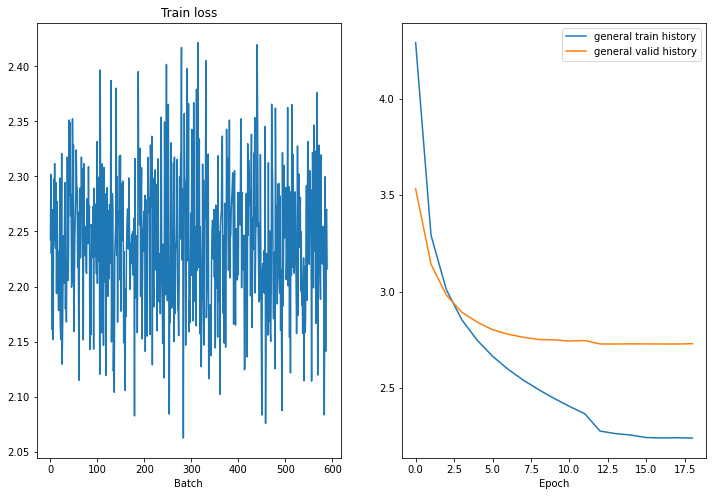

Epoch: 20 | Time: 7m 12s
	Train Loss: 2.240 | Train PPL:   9.395
	 Val. Loss: 2.729 |  Val. PPL:  15.319


In [19]:
#TF train
import time
import math
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

train_history = []
valid_history = []

N_EPOCHS = 20
CLIP = 1
TF = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    if epoch > 2 and valid_history[-2] < valid_history[-1] :
        if optimizer.param_groups[0]['lr'] > 1e-6:
            optimizer.param_groups[0]['lr'] /= 10
        else:
            print(f"Early stop at {epoch} epoch!")
            break

    start_time = time.time()
    
    train_loss = train(network, train_loader, optimizer, CLIP, TF, train_history, valid_history)
    valid_loss = evaluate(network, val_loader)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
           
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(network.state_dict(), 'best-val-model.pt')

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [20]:
torch.save(network.state_dict(), 'att_model_20_epoch.pt')

## Inception и получение результатов


In [21]:
# загружаем inception, чтобы можно было прогонять через него новые картинки, 
# получать их эмбеддинги и генерировать описания с помощью нашей сети
from beheaded_inception3 import beheaded_inception_v3
inception = beheaded_inception_v3().train(False)

/usr/local/lib/python3.7/dist-packages/torchvision/models/inception.py:82: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  ' due to scipy/scipy#11299), please set init_weights=True.', FutureWarning)
Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


### Сгенерируем описание

In [22]:
@torch.no_grad()
def generate_caption(image, model, vocabulary, t=1,
                     sample=True, max_len=100, mode='distrib'):
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3
    model.eval()
    vocab = vocabulary.get_itos()
    with torch.no_grad():
        image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)
        vectors_8x8, vectors_neck, logits = inception(image[None])        
        input = torch.ones(1,1,dtype=torch.int).to(device)
        result = []
        h,c = None, None
        if mode == 'distrib':
            for _ in range(max_len):
                logit, h, c = model(vectors_neck.to(device), input, h, c, TF=0)
                probs = torch.softmax(logit[0,0]/t, dim=-1)            
                distribution = Categorical(probs)
                sampled = distribution.sample()
                result.append(vocab[sampled.item()])
                if result[-1] == '<eos>':
                    break 
                input = torch.tensor([[sampled.item()]]).to(device)
        if mode == 'greedy':
            for _ in range(max_len):
                logit, h, c = model(vectors_neck.to(device), input, h, c, TF=0)
                input = logit.argmax(-1)
                result.append(vocab[input.item()])
                if result[-1] == '<eos>':
                    break                               
    return result

### Скачаем пару картинок, чтобы проверить качество:

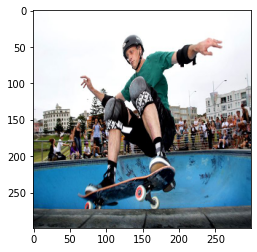

In [23]:
from matplotlib import pyplot as plt
import cv2
%matplotlib inline

#sample image
!wget --quiet -O  img.jpg https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg
img = plt.imread('img.jpg')
img =  cv2.resize(src=img, dsize=(299, 299), interpolation=cv2.INTER_CUBIC).astype('float32') / 255
plt.imshow(img)

In [25]:
print(' '.join(generate_caption(img, network, vocabulary, t=1, mode='greedy')[:-1]).capitalize())

A man riding a skateboard down a ramp


In [24]:
for _ in range(5):
    print(' '.join(generate_caption(img, network, vocabulary, t=1)[:-1]).capitalize())

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


A person is riding a skateboard on the ground
There is a man on a skateboard jumping on the air as another person extending his skateboard
Players jumping on a ramp of practicing a scenery
A man jumps high over a pile of rocks
A skateboarder performing tricks on a skateboard close to legs


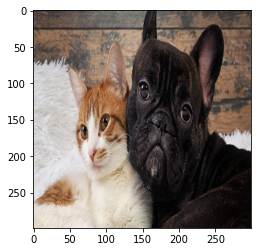

In [26]:
!wget --quiet -O  img.jpg http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg 
img = plt.imread('img.jpg')
img =  cv2.resize(src=img, dsize=(299, 299), interpolation=cv2.INTER_CUBIC).astype('float32') / 255

plt.imshow(img)
plt.show()

In [28]:
print(' '.join(generate_caption(img, network, vocabulary, mode='greedy')[:-1]).capitalize())

A cat is sitting on a couch next to a stuffed animal


In [27]:
for _ in range(5):
    print(' '.join(generate_caption(img, network, vocabulary, t=0.5)[:-1]).capitalize())

A cat that is holding a yellow and white cat
A cat is wearing a hat and blue tie
A cat is sitting in a chair wearing a tie
A cat with a hat is standing next to a stuffed animal
A cat laying on a couch with a remote control


# Demo

ВОТ ЩАС БУИТ СМИШНО

Теперь ищите свои картинки, применяйте к ним сетку, смотрите че получится, реализовывайте вариативную часть =)

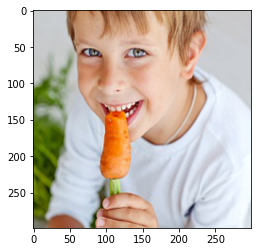

In [29]:
!wget --quiet -O  img.jpg https://kidsdiscover.com/wp-content/uploads/2013/11/x.jpg
img = plt.imread('img.jpg')
img =  cv2.resize(src=img, dsize=(299, 299), interpolation=cv2.INTER_CUBIC).astype('float32') / 255

plt.imshow(img)
plt.show()

In [30]:
print(' '.join(generate_caption(img, network, vocabulary, mode='greedy')[:-1]).capitalize())

A baby is eating a piece of pizza


In [31]:
for _ in range(5):
    print(' '.join(generate_caption(img, network, vocabulary, t=0.5)[:-1]).capitalize())

A small child is holding a small white frisbee
A baby is eating a piece of cake
A small child is taking a picture of a fence
A baby in a white shirt eating a carrot
A black and white photo of a person with a toothbrush


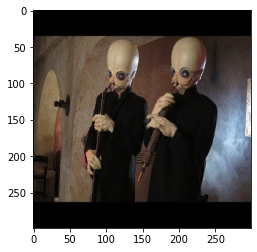

In [38]:
!wget --quiet -O  img.jpg https://i.ytimg.com/vi/Bwu3JqtaZcg/hqdefault.jpg
img = plt.imread('img.jpg')
img =  cv2.resize(src=img, dsize=(299, 299), interpolation=cv2.INTER_CUBIC).astype('float32') / 255
plt.imshow(img)
plt.show()

In [39]:
print(' '.join(generate_caption(img, network, vocabulary, mode='greedy')[:-1]).capitalize())

A man holding a wii remote in his hand


In [40]:
for _ in range(5):
    print(' '.join(generate_caption(img, network, vocabulary, t=0.5)[:-1]).capitalize())

A man in a black shirt and a black tie is holding a blue umbrella
A man is holding a smart phone on top of a couch
A group of people standing next to each other in a room
A man holding a wii remote while standing in front of a wall
A man and a woman standing near a mirror


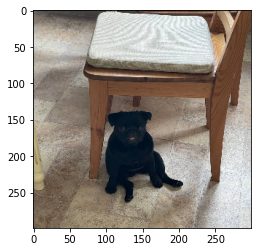

In [32]:
img = plt.imread('234.jpg')
img =  cv2.resize(src=img, dsize=(299, 299), interpolation=cv2.INTER_CUBIC).astype('float32') / 255
plt.imshow(img)
plt.show()

In [33]:
print(' '.join(generate_caption(img, network, vocabulary, mode='greedy')[:-1]).capitalize())

A black and white dog sitting on a bed


In [34]:
for _ in range(5):
    print(' '.join(generate_caption(img, network, vocabulary, t=0.15)[:-1]).capitalize())

A black and white dog sitting on a bed
A black and white dog sitting on a bed
A black and white cat sitting on a chair
A black and white dog sitting on a bed
A black and white dog sitting on a bed


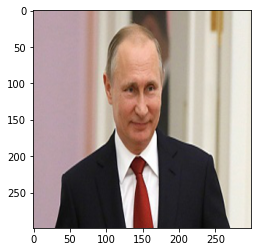

In [35]:
img = plt.imread('555.jpg')
img =  cv2.resize(src=img, dsize=(299, 299), interpolation=cv2.INTER_CUBIC).astype('float32') / 255

plt.imshow(img)
plt.show()

In [36]:
' '.join(generate_caption(img, network, vocabulary, mode='greedy')[:-1]).capitalize()

'A man in a suit and tie'

In [37]:
for _ in range(5):
    print(' '.join(generate_caption(img, network, vocabulary, t=0.5)[:-1]).capitalize())

A man in a suit and tie
A man wearing a suit and tie
A man wearing a jacket and tie
A man wearing a suit and tie
A man in a suit and tie
